In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [2]:

MAX_GAP = 3600   # 1 h en secondes
MIN_GAP = 600     # 1 min en secondes

In [3]:
df = pd.read_csv("../vessel-total-clean-final.csv")

# Convertir la colonne date en datetime
df['base_date_time'] = pd.to_datetime(df['base_date_time'])

# Trier par mmsi + date (si plusieurs navires)
df = df.sort_values(['mmsi', 'base_date_time'])

In [4]:
df = df.sort_values(['mmsi', 'base_date_time'])
df['delta'] = df.groupby('mmsi')['base_date_time'].diff().dt.total_seconds()

# Choisis ici le MMSI à visualiser
mmsi_example = df['mmsi'].unique()[5]
df_boat = df[df['mmsi'] == mmsi_example].copy()

gaps = df_boat[df_boat['delta'] > MAX_GAP]


In [5]:
# ── Diagnostic des gaps réels ──
print(f"=== Diagnostic pour le navire {mmsi_example} ===")
for i in range(1, len(df_boat)):
    t0 = df_boat.iloc[i-1]['base_date_time']
    t1 = df_boat.iloc[i  ]['base_date_time']
    gap = (t1 - t0).total_seconds()
    if gap > MAX_GAP:
        print(f"Gap de {gap:.0f}s entre lignes {i-1} et {i} : {t0} → {t1}")
print("=== Fin du diagnostic ===\n")

=== Diagnostic pour le navire 241452000 ===
Gap de 15870s entre lignes 8 et 9 : 2023-05-25 12:07:03 → 2023-05-25 16:31:33
Gap de 4920s entre lignes 9 et 10 : 2023-05-25 16:31:33 → 2023-05-25 17:53:33
Gap de 86639s entre lignes 71 et 72 : 2023-05-25 23:57:51 → 2023-05-27 00:01:50
Gap de 86490s entre lignes 639 et 640 : 2023-05-27 23:58:34 → 2023-05-29 00:00:04
Gap de 24023s entre lignes 1022 et 1023 : 2023-05-29 12:44:22 → 2023-05-29 19:24:45
Gap de 86688s entre lignes 1184 et 1185 : 2023-05-29 23:55:16 → 2023-05-31 00:00:04
=== Fin du diagnostic ===



In [6]:
def predict_gap(segment_df, model, step=60):
    
    row_prev = segment_df.iloc[0]
    row_next = segment_df.iloc[1]
    t0 = row_prev['base_date_time']
    total_s = int((row_next['base_date_time'] - t0).total_seconds())
    n_steps = total_s // step

    # abort if gap is too large
    if total_s > MAX_GAP:
        raise ValueError('Gap > 1 h : pas de comblement')

    # interpolation linéaire de sog et cog
    sogs = np.linspace(row_prev['sog'], row_next['sog'], n_steps+1)
    cogs = np.linspace(row_prev['cog'], row_next['cog'], n_steps+1)

    # état initial
    state = {
        'lat':    row_prev['lat'],
        'lon':    row_prev['lon'],
        'length': row_prev['length'],
        'draft':  row_prev['draft']
    }

    filled = []
    for i in range(1, n_steps):
        state['sog']     = sogs[i]
        state['cog']     = cogs[i]
        state['heading'] = row_prev['heading']

        X = pd.DataFrame([{**state, 'delta_seconds': step}])
        # réordonner les colonnes comme à l'entraînement
        try:
            X = X[model.feature_names_in_]
        except AttributeError:
            feature_order = ['lat','lon','sog','cog','heading','length','draft','delta_seconds']
            X = X[feature_order]

        lat_p, lon_p = model.predict(X)[0]
        t_pred = t0 + pd.Timedelta(seconds=i*step)

        filled.append({
            'mmsi':           row_prev['mmsi'],
            'base_date_time': t_pred,
            'lat':            lat_p,
            'lon':            lon_p
        })
        # mise à jour de la position pour l’itération suivante
        state['lat'], state['lon'] = lat_p, lon_p

    return pd.DataFrame(filled)

In [7]:
model = joblib.load("trajectoire.pkl")

# ── Paramètres pour le comblement ──
step = 300   
min_gap_fill = MIN_GAP
max_gap_fill = MAX_GAP

all_filled = []
for i in range(1, len(df_boat)):
    gap = df_boat.iloc[i]['delta']
    # on saute si gap trop court ou trop long
    if (gap <= min_gap_fill) or (gap > max_gap_fill):
        continue

    row_prev = df_boat.iloc[i-1]
    row_next = df_boat.iloc[i]
    segment  = pd.DataFrame([row_prev, row_next])

    df_seg = predict_gap(segment, model, step=step)
    all_filled.append(df_seg)

filled_df = pd.concat(all_filled, ignore_index=True)
print("✅ Points prédits :", len(filled_df))


✅ Points prédits : 72


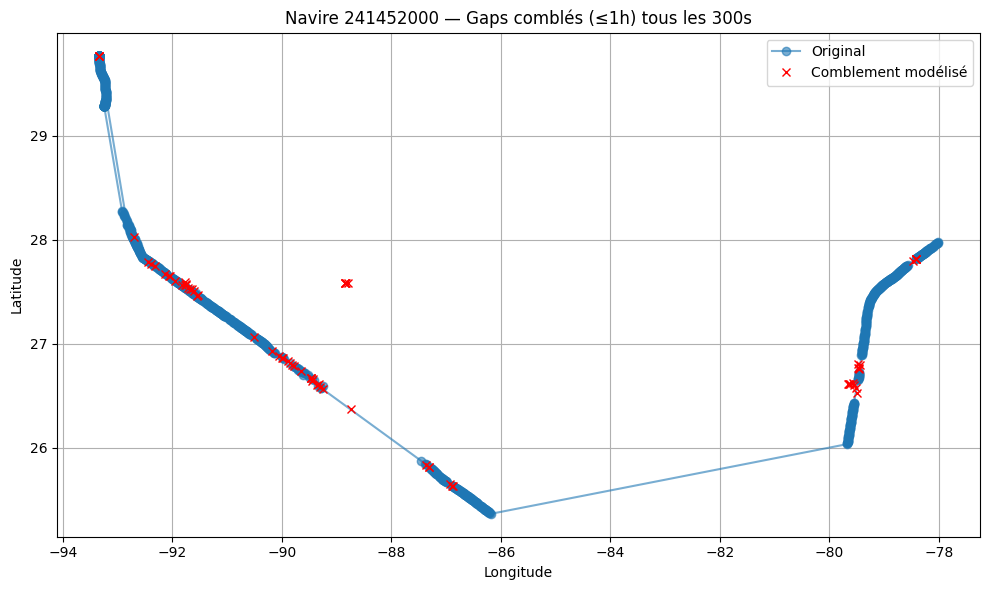

In [8]:
plt.figure(figsize=(10,6))
# trajectoire mesurée
plt.plot(df_boat['lon'], df_boat['lat'], 'o-', label='Original', alpha=0.6)
# prédictions comblées
plt.plot(filled_df['lon'], filled_df['lat'], 'x', label='Comblement modélisé', color='red')

plt.title(f"Navire {mmsi_example} — Gaps comblés (≤1h) tous les {step}s")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# %%  — Carte Folium
import folium

# centre grossier : milieu de la trajectoire
center = [
    0.5 * (df_boat.lat.min() + df_boat.lat.max()),
    0.5 * (df_boat.lon.min() + df_boat.lon.max())
]

m = folium.Map(location=center, zoom_start=7, tiles="cartodbpositron")

# ---------- points originaux (bleu) ----------
orig_layer = folium.FeatureGroup(name="Positions originales").add_to(m)
for lat, lon, t in zip(df_boat.lat, df_boat.lon, df_boat.base_date_time):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="#1f77b4",              # contour bleu
        fill=True, fill_color="#1f77b4", fill_opacity=0.8,
        tooltip=str(t)
    ).add_to(orig_layer)

# ---------- points comblés (rouge) ----------
if not filled_df.empty:
    fill_layer = folium.FeatureGroup(name="Positions comblées").add_to(m)
    for lat, lon, t in zip(filled_df.lat, filled_df.lon, filled_df.base_date_time):
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color="#d62728",
            fill=True, fill_color="#d62728", fill_opacity=0.9,
            tooltip=f"Comblé : {t}"
        ).add_to(fill_layer)

# bascule d’affichage
folium.LayerControl().add_to(m)

m    # affiche la carte interactive dans le notebook

In [10]:
# %% — Carte Folium : toutes les trajectoires + points comblés
import folium
import pandas as pd

# centre grossier couvrant tout le jeu (lat/lon moyens)
center_all = [df.lat.mean(), df.lon.mean()]
m = folium.Map(location=center_all, zoom_start=6, tiles="cartodbpositron")

# ------------------------------------------------------------------
# boucle MMSI : même fonctionnement que ta cellule d’origine
# ------------------------------------------------------------------
for mmsi, grp in df.sort_values("base_date_time").groupby("mmsi"):
    print(f"Trajectoire MMSI {mmsi} : {len(grp)} points")
    # ---------- positions originales (bleu) ----------
    orig_layer = folium.FeatureGroup(
        name=f"{mmsi} • positions originales", show=False
    ).add_to(m)

    for lat, lon, t in zip(grp.lat, grp.lon, grp.base_date_time):
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color="#1f77b4",
            fill=True, fill_color="#1f77b4", fill_opacity=0.8,
            tooltip=f"{mmsi} • {t}"
        ).add_to(orig_layer)


    # ---------- positions comblées (rouge) ----------
    if "filled_df" in globals():
        grp_filled = filled_df[filled_df.mmsi == mmsi]
        if not grp_filled.empty:
            fill_layer = folium.FeatureGroup(
                name=f"{mmsi} • positions comblées", show=False
            ).add_to(m)

            for lat, lon, t in zip(
                grp_filled.lat, grp_filled.lon, grp_filled.base_date_time
            ):
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=3,
                    color="#d62728",
                    fill=True, fill_color="#d62728", fill_opacity=0.9,
                    tooltip=f"{mmsi} • comblé : {t}"
                ).add_to(fill_layer)

# contrôle d’affichage
folium.LayerControl(collapsed=False).add_to(m)

m   # affiche la carte interactive

Trajectoire MMSI 205776000 : 1585 points
Trajectoire MMSI 209513000 : 2542 points
Trajectoire MMSI 212040000 : 1859 points
Trajectoire MMSI 215583000 : 1492 points
Trajectoire MMSI 228075700 : 2576 points
Trajectoire MMSI 241452000 : 1561 points
Trajectoire MMSI 241770000 : 2158 points
Trajectoire MMSI 244561000 : 3852 points
Trajectoire MMSI 244810614 : 2163 points
Trajectoire MMSI 245021000 : 1686 points
Trajectoire MMSI 248392000 : 2413 points
Trajectoire MMSI 248680000 : 2556 points
Trajectoire MMSI 248895000 : 2623 points
Trajectoire MMSI 249086000 : 4394 points
Trajectoire MMSI 255805583 : 1191 points
Trajectoire MMSI 257087080 : 1849 points
Trajectoire MMSI 305291000 : 1376 points
Trajectoire MMSI 309587000 : 2147 points
Trajectoire MMSI 311000808 : 3082 points
Trajectoire MMSI 311070400 : 1924 points
Trajectoire MMSI 319093800 : 2346 points
Trajectoire MMSI 319106900 : 2373 points
Trajectoire MMSI 319499000 : 1912 points
Trajectoire MMSI 319963000 : 2191 points
Trajectoire MMSI

KeyboardInterrupt: 